In [2]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random
import pickle

In [3]:
with open('/home/ad/dng/raw_list.pkl','rb') as f:
    raw_list = pickle.load(f)
    raw_array = np.stack(raw_list)
    del raw_list
    raw_array[raw_array>255] = 255
    raw_array = raw_array.astype(np.float32)/255.0
with open('/home/ad/dng/rgb_list.pkl','rb') as f:
    rgb_list = pickle.load(f)
    rgb_array = np.stack(rgb_list)
    del rgb_list
    rgb_array = rgb_array.astype(np.float32)/255.0

In [50]:
class SimDataset(Dataset):
    def __init__(self, raw_array, rgb_array,count, transform=None):
        # self.flist = []
        self.size = 1024
        self.stride = 2
        self.count = count
        self.raw_array = raw_array
        self.rgb_array = rgb_array
        # for x in tqdm(path.iterdir()):
        #     if x.is_file():
        #         self.flist.append(x)
        #         raw = rawpy.imread(str(x))
        #         self.raw_list.append(raw.raw_image)
        #         self.rgb_list.append(raw.postprocess())

#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
        self.source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):  
        stride = self.stride
        sample_num = idx%len(self.raw_array)
#         raw = rawpy.imread(str(self.flist[idx]))
        raw_image = self.raw_array[sample_num]
        rgb = self.rgb_array[sample_num]
        x = random.randint(0,int((raw_image.shape[0]-train_set.size-1)/stride))
        y = random.randint(0,int((raw_image.shape[1]-train_set.size-1)/stride))
        raw_crop = raw_image[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
        rgb_crop = rgb[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
#         if self.transform:
#             raw_image = self.transform(raw_image.astype(np.float32))
#             rgb = self.transform(rgb)
        return [self.source_transform(raw_crop), self.target_transform(rgb_crop),rgb]


In [51]:
directory = Path('/content/intern_task')
train_set = SimDataset(raw_array,rgb_array, 1000)

In [6]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        
        layer3 = self.layer3_1x1(layer3)
#         x = self.upsample(layer3)
#         print("x shape:",x.shape)
#         print("layer3 shape:",layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [7]:
model = torch.load('resnet18_64.pt')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
a  = [2,3,4,5,34,5,3]
a[:2],a[2:]

([2, 3], [4, 5, 34, 5, 3])

In [8]:
        source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])

In [27]:
inp = source_transform(raw_array[0][:64,:64]).unsqueeze(0).to(device)

In [42]:
inp = train_set[0][0].unsqueeze(0)

In [35]:
out = model(inp.to(device))

In [11]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [ ]:
inv_normalize(out.detach().cpu()[0]).permute(1,2,0)

In [52]:
inp = train_set[0][0].unsqueeze(0)
out = model(inp.to(device))
plt.imshow(inv_normalize(out.detach().cpu()[0]).permute(1,2,0))

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 3.95 GiB total capacity; 1.80 GiB already allocated; 202.69 MiB free; 2.40 GiB reserved in total by PyTorch)

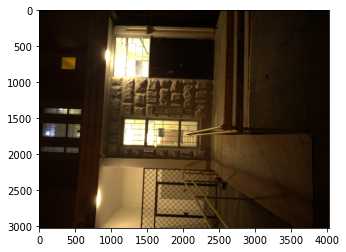

In [14]:
plt.imshow(train_set[0][2])